# 3.6 Reconciling projections

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#3.6-Reconciling-projections" data-toc-modified-id="3.6-Reconciling-projections-1">3.6 Reconciling projections</a></span><ul class="toc-item"><li><span><a href="#3.6.1-Introduction" data-toc-modified-id="3.6.1-Introduction-1.1">3.6.1 Introduction</a></span></li><li><span><a href="#3.6.1.1-Projections" data-toc-modified-id="3.6.1.1-Projections-1.2">3.6.1.1 Projections</a></span></li><li><span><a href="#3.6.1.2-Changing-Projections" data-toc-modified-id="3.6.1.2-Changing-Projections-1.3">3.6.1.2 Changing Projections</a></span></li><li><span><a href="#3.6.2-Requirements" data-toc-modified-id="3.6.2-Requirements-1.4">3.6.2 Requirements</a></span><ul class="toc-item"><li><span><a href="#3.6.2.1-Run-the-pre-requisite-scripts" data-toc-modified-id="3.6.2.1-Run-the-pre-requisite-scripts-1.4.1">3.6.2.1 Run the pre-requisite scripts</a></span></li></ul></li><li><span><a href="#3.6.3-Reconcile-the-datasets" data-toc-modified-id="3.6.3-Reconcile-the-datasets-1.5">3.6.3 Reconcile the datasets</a></span><ul class="toc-item"><li><span><a href="#3.6.3.1-load-an-exemplar-dataset" data-toc-modified-id="3.6.3.1-load-an-exemplar-dataset-1.5.1">3.6.3.1 load an exemplar dataset</a></span></li><li><span><a href="#3.6.3.2-get-information-from-source-file" data-toc-modified-id="3.6.3.2-get-information-from-source-file-1.5.2">3.6.3.2 get information from source file</a></span></li><li><span><a href="#3.6.3.4-reprojection" data-toc-modified-id="3.6.3.4-reprojection-1.5.3">3.6.3.4 reprojection</a></span></li><li><span><a href="#3.6.3.5-crop" data-toc-modified-id="3.6.3.5-crop-1.5.4">3.6.3.5 crop</a></span></li></ul></li><li><span><a href="#3.6.3.6-Putting-this-together" data-toc-modified-id="3.6.3.6-Putting-this-together-1.6">3.6.3.6 Putting this together</a></span></li><li><span><a href="#3.6.4-Interpolate-and-save-the-LAI-data" data-toc-modified-id="3.6.4-Interpolate-and-save-the-LAI-data-1.7">3.6.4 Interpolate and save the LAI data</a></span></li><li><span><a href="#3.6.7-Summary" data-toc-modified-id="3.6.7-Summary-1.8">3.6.7 Summary</a></span></li></ul></li></ul></div>

## 3.6.1 Introduction

This section of notes is optional to the course, and the tutor may decide *not* to go through this in class. 

That said, the information and examples contained here can be very useful for accessing and processing certain types of geospatial data.

In particular, we deal with obtaining climate data records from [ECMWF](http://apps.ecmwf.int/datasets/data/era40-daily/levtype=sfc) that we will later use for model fitting. These data come in a [netcdf](https://confluence.ecmwf.int/display/CKB/What+are+NetCDF+files+and+how+can+I+read+them) format (commonly used for climate data) with a grid in latitude/longitude. To 'overlay' these data with another dataset (e.g. the MODIS LAI product that we have been using) in a different (equal area) projection, we use the `gdal` function

    gdal.ReprojectImage(src, dst, src_proj, dst_proj, interp)
       
where:

    src      : a source dataset that we want to process 
    dst      : a blank destination dataset that we set up with the 
               required (output) data type, shape, and geotransform and projection
    src_proj : the source dataset projection wkt 
    dst_proj : the destination projection wkt 
    interp   : the required interpolation method, e.g. gdalconst.GRA_Bilinear
    
where wkt stands for [well known text](https://en.wikipedia.org/wiki/Well-known_text) and is a projection format string.

Other codes we use are ones we have developed earlier.

In these notes, we will learn:

    * how to access an ECMWF daily climate dataset (from ERA interim)
    * how to reproject the dataset to match another spatial dataset (MODIS LAI)
    
We will then save some datasets that we will use later in the notes. For this reason, it's possile to skip this section, and return to it later.

## 3.6.1.1 Projections

For various reasons, different geospatial datasets will come in different [projections](http://desktop.arcgis.com/en/arcmap/10.3/guide-books/map-projections/what-are-map-projections.htm).

Considering for example, satellite-derived data from Low Earth Orbit [LEO](https://en.wikipedia.org/wiki/Low_Earth_orbit), the satellite sensor will typically obtain image data in a swath as it passes over the Earth surface. Projected onto the Earth surface, this appears as a strip of data:

![https://earthobservatory.nasa.gov/Features/LDCMLongSwath](images/long_swath_map_720.png)

but in the satellite data recording system, the data are stored as a regular array. We call such satellite data 'swath' (or 'swath-like') data (in the satellite imager coordinate system) and we may obtain data products in anything up to [Level 2](https://earthdata.nasa.gov/earth-science-data-systems-program/policies/data-information-policy/data-levels) in such a form.

These data are often difficult for data scientists to deal with. They generally prefer to have a dataset mapped to a uniform space-time grid, even though this may involve some re-sampling, which can sometimes result in loss of information. The convenience of a uniform space-time grid means that you can. for example, look at dynamic features (information over time).

The properties of the 'uniform space-time grid' will depend on [user requirements](http://desktop.arcgis.com/en/arcmap/10.3/tools/coverage-toolbox/choosing-a-map-projection.htm). For some, it is important to have an [equal area projection](https://www.giss.nasa.gov/tools/gprojector/help/projections/), one where the 'pixel size' is consistent throughout the dataset. 

![https://www.giss.nasa.gov/tools/gprojector/hehttps://www.giss.nasa.gov/tools/gprojector/help/projections/CylindricalEqualArea.png](images/CylindricalEqualArea.png)

even if this is not convenient for viewing some areas of the Earth (map projections are very political!).

Or other factors may be more important, such as user familiarity with a simple latitude/longitude grid typically used by climate scientists. 

![https://www.giss.nasa.gov/tools/gprojector/help/projections/CylindricalStereographic.png](images/CylindricalStereographic.png)

For others, a conformal projection (preserving angles, as a cost of distance distortion) may be vital.

![https://www.giss.nasa.gov/tools/gprojector/help/projections/AdamsHemisphereInASquare.png](images/AdamsHemisphereInASquare.png)

We have see that MODIS data products, for example, come described in an equal area sinusoidal grid:

![https://www.giss.nasa.gov/tools/gprojector/help/projections/Sinusoidal.png](images/Sinusoidal.png).

but the data for high latitudes and longitudes appears very distorted.




We must accept then, that dealing with geospatial data must involve some understanding of projections, as well as practically, how to convert datasets between different projections.

**Earth shape**

One factor that can make life even more complicated than using just different projections is the use of different assumptions about the Earth shape (e.g. sphere, spheroid, radius variations). Often, the particular assumptions used by a group of users is just a result of history: it is what has 'traditionally' used for that purpose. It can be seen as too bothersome or expensive to change this.

Since we can convert between different projections though, we can also deal with different Earth shape assumptions. We just have to be very clear about what was assumed. If at all possible, the geospatial datasets themselves should contain a full description of the projection and Earth shape assumed, but this is not always the case.

The datasets we will mostly be dealing are in the following projections:

* MODIS Sinusoidal ([tested](https://github.com/SciTools/cartopy/blob/master/lib/cartopy/tests/crs/test_sinusoidal.py)), which assumes a custom spherical Earth of radius 6371007.181 m. In `cartopy` this is given as [Sinusoidal.MODIS](https://github.com/SciTools/cartopy/blob/master/lib/cartopy/crs.py):
   
        # MODIS data products use a Sinusoidal projection of a spherical Earth
        # http://modis-land.gsfc.nasa.gov/GCTP.html
        Sinusoidal.MODIS = Sinusoidal(globe=Globe(ellipse=None,
                                              semimajor_axis=6371007.181,
                                              semiminor_axis=6371007.181))
                                              
   In the MODIS data hdf products, the projection information is stored directly. Extracted as a wkt, this is:
   
       [[PROJCS["unnamed",
           GEOGCS["Unknown datum based upon the custom spheroid",
               DATUM["Not_specified_based_on_custom_spheroid",
                   SPHEROID["Custom spheroid",6371007.181,0]],
           PRIMEM["Greenwich",0],
           UNIT["degree",0.0174532925199433]],
       PROJECTION["Sinusoidal"],
       PARAMETER["longitude_of_center",0],
       PARAMETER["false_easting",0],
       PARAMETER["false_northing",0],
       UNIT["metre",1,AUTHORITY["EPSG","9001"]]]

    According to [SR-ORG](http://spatialreference.org/ref/sr-org/6965/), the MODIS projection uses a spherical projection ellipsoid but a WGS84 datum ellipsoid. This is not quite the same as the definition in the wkt above. 
   
    It is also defined by SR-ORG with the EPSG code [6974](http://spatialreference.org/ref/sr-org/6974/) for software that can use `semi_major` and `semi_minor` projection definitions.
    
    Some software may use the simpler [6965](http://spatialreference.org/ref/sr-org/6965/) definition (or the older [6842](http://spatialreference.org/ref/sr-org/6842/)).
    
    The MODIS projection 6974 is given as:
    
        PROJCS["MODIS Sinusoidal",
            GEOGCS["WGS 84",
                DATUM["WGS_1984",
                    SPHEROID["WGS 84",6378137,298.257223563,
                        AUTHORITY["EPSG","7030"]],
                AUTHORITY["EPSG","6326"]],
            PRIMEM["Greenwich",0,
                AUTHORITY["EPSG","8901"]],
            UNIT["degree",0.01745329251994328,
                AUTHORITY["EPSG","9122"]],
            AUTHORITY["EPSG","4326"]],
        PROJECTION["Sinusoidal"],
        PARAMETER["false_easting",0.0],
        PARAMETER["false_northing",0.0],
        PARAMETER["central_meridian",0.0],
        PARAMETER["semi_major",6371007.181],
        PARAMETER["semi_minor",6371007.181],
        UNIT["m",1.0],
        AUTHORITY["SR-ORG","6974"]]
        
     None of these codes are defined in `gdal` (see files in $GDAL_DATA/*.wkt for details), so to use them, we have to take the file from [SR-ORG](http://spatialreference.org/ref/sr-org/6974/ogcwkt/).
     
     For the datasets we are using, it makes no real difference whether the projection information from the file is used instead of MODIS projection 6974, so we will use that from the file. For other areas and especially for any higher spatial resolution datasets, it is worth investigating which is more appropriate.
 
* ECMWF netcdf format (derived from GRIB) [ERA Interim](https://www.ecmwf.int/en/forecasts/datasets/archive-datasets/reanalysis-datasets/era-interim) climate datasets (1979-Present). These are geographic coordinates (latitude/longitude) in a custom spheroid with a radius 6371200 m.  

This information can be obtained from any example of a GRIB file, as we shall see below. As a wkt, this is:

        ['GEOGCS["Coordinate System imported from GRIB file",
        DATUM["unknown",SPHEROID["Sphere",6371200,0]],
        PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]']
        
* A more common spheroid to use is [WGS84](https://confluence.qps.nl/qinsy/en/world-geodetic-system-1984-wgs84-29855173.html), although even in that case there are multiple 'realisations' available (used mainly by the DoD). Users should generally implement that given in EPSG code [4326](http://spatialreference.org/ref/epsg/4326/) used by the GPS system, for example.

        [GEOGCS["WGS 84",
            DATUM["WGS_1984",
                SPHEROID["WGS 84",6378137,298.257223563,
                    AUTHORITY["EPSG","7030"]],
                AUTHORITY["EPSG","6326"]],
            PRIMEM["Greenwich",0,
                AUTHORITY["EPSG","8901"]],
            UNIT["degree",0.01745329251994328,
                AUTHORITY["EPSG","9122"]],
            AUTHORITY["EPSG","4326"]]]

## 3.6.1.2 Changing Projections

We can conveniently use the Python [`cartopy`](https://scitools.org.uk/cartopy/docs/v0.16/) package to explore projections.

We download an image taken from the satellite sensor ([SEVIRI](https://www.esa.int/Our_Activities/Observing_the_Earth/Meteosat/SEVIRI)):

![http://www.esa.int/spaceinimages/Images/2005/12/Artist_s_view_of_SEVIRI_in_orbit](images/Artist_s_view_of_SEVIRI_in_orbit_node_full_image_2.png)

The sensor builds up images of the Earth disc from geostationarty orbit, actioned by the platform spin.

![http://www.esa.int/spaceinimages/Images/2015/08/MSG-4_Europe_s_latest_weather_satellite_delivers_first_image](images/MSG-4_Europe_s_latest_weather_satellite_delivers_first_image_node_full_image_2.png)

In the code below, we plot the dataset in the 'earth disk' (Orthographic) projection, then re-map it to the equal area Sinusoidal projection.

Retrieving image...
Projecting and plotting image (this may take a while)...


/Users/plewis/anaconda/envs/geog0111/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


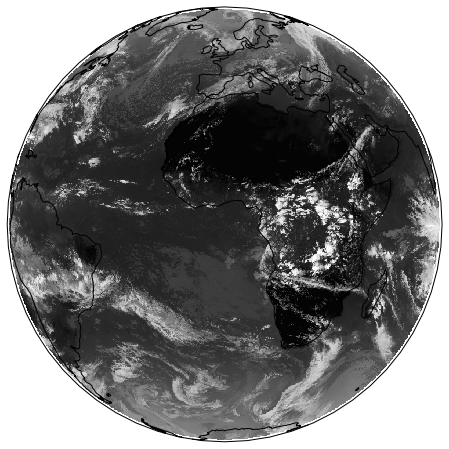

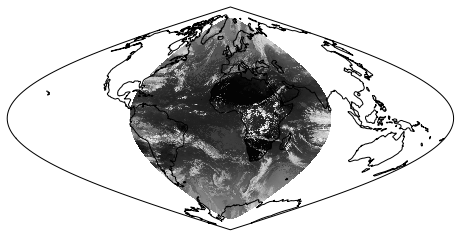

In [51]:
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen
from io import BytesIO
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

'''
=====================================================
Don't run this cell in class as it will take too long!

                 Use it for homework
=====================================================
'''

'''
from https://scitools.org.uk/cartopy/docs/v0.16/\
            gallery/geostationary.html#sphx-glr-gallery-geostationary-py
'''
def geos_image():
    """
    Return a specific SEVIRI image by retrieving it from a github gist URL.

    Returns
    -------
    img : numpy array
        The pixels of the image in a numpy array.
    img_proj : cartopy CRS
        The rectangular coordinate system of the image.
    img_extent : tuple of floats
        The extent of the image ``(x0, y0, x1, y1)`` referenced in
        the ``img_proj`` coordinate system.
    origin : str
        The origin of the image to be passed through to matplotlib's imshow.

    """
    url = ('https://gist.github.com/pelson/5871263/raw/'
           'EIDA50_201211061300_clip2.png')
    img_handle = BytesIO(urlopen(url).read())
    img = plt.imread(img_handle)
    img_proj = ccrs.Geostationary(satellite_height=35786000)
    img_extent = [-5500000, 5500000, -5500000, 5500000]
    return img, img_proj, img_extent, 'upper'

print('Retrieving image...')
img, crs, extent, origin = geos_image()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1,projection=\
                     ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0))
ax.coastlines()
ax.set_global()
ax.imshow(img, transform=crs, extent=extent, origin=origin, cmap='gray')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection=\
                     ccrs.Sinusoidal(central_longitude=0.0, \
                        false_easting=0.0, false_northing=0.0))
ax.coastlines()
ax.set_global()
print('Projecting and plotting image (this may take a while)...')
ax.imshow(img, transform=crs, extent=extent, origin=origin, cmap='gray')

The full list of [`cartopy` projections](https://scitools.org.uk/cartopy/docs/v0.16/crs/projections.html) is quite entensive.

**Exercise 3.6.1** Extra Homework

* Explore some different types of projection using `cartopy` and make a note of their features.
* Read up (follow the links in the text above) on projections.

In [1]:
#do exercise here

## 3.6.2 Requirements

We will need to:

* make sure we have the MODIS LAI dataset locally
* read them in for a given country.
* register with ecmwf, install ecmwfapi
* get the temperature datasset from ECMWF for 2006 and 2017 for Europe
* get the country borders shapefile

**Set up the conditions**


In [1]:
# required general imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import os
from pathlib import Path
import gdal
from datetime import datetime, timedelta
import cartopy.crs as ccrs

In [2]:
'''
Set the country code and year to be used here
'''
country_code = 'UK'
year = 2017
shpfile = "data/TM_WORLD_BORDERS-0.3.shp"

### 3.6.2.1 Run the pre-requisite scripts

**Make sure you register with ECMWF**
* register with ECMWF and install the API
    
    Follow the [ECMWF instructions](https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets)

**Sort data prerequisities** 
* Run the codes in the [prerequisites section](Chapter3_6A_GDAL_Reconciling_projections_prerequisites.ipynb)

    OR
    
* Run the [prerequisites script]:

In [3]:
# install ecmwf api -- do this once only
ECMWF = 'https://software.ecmwf.int/wiki/download/attachments/56664858/ecmwf-api-client-python.tgz'
try:
    from ecmwfapi import ECMWFDataServer
except:
    import os
    if os.name == 'nt':
        # on windows
        !pip install $ECMWF
    else:
        # on Unix/Linux
        !pip install --user $ECMWF

In [23]:
# just make sure the pre-requisites are run
%run geog0111/Chapter3_6A_prerequisites.py $country_code 2016

europe_data_2016_2017.nc exists
GEOGCS["Coordinate System imported from GRIB file",DATUM["unknown",SPHEROID["Sphere",6371200,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]
PROJCS["MODIS Sinusoidal",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Sinusoidal"],PARAMETER["false_easting",0.0],PARAMETER["false_northing",0.0],PARAMETER["central_meridian",0.0],PARAMETER["semi_major",6371007.181],PARAMETER["semi_minor",6371007.181],UNIT["m",1.0],AUTHORITY["SR-ORG","6974"]]
data/europe_data_2016.nc
data/europe_data_2017.nc


<Figure size 432x288 with 0 Axes>

In [24]:
# read in the LAI data for given country code
tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")
        
fname = f'lai_data_{year}_{country_code}.npz'
ofile = Path('data')/fname
try:
    # read data from npz file
    lai = np.load(ofile)
except:
    print(f"{ofile} doesn't exist: sort the pre-requisites")


## 3.6.3 Reconcile the datasets

In this section, we will use `gdal` to transform two datasets into the same coordinate system.

To do this, we identify one dataset with the projection and geographic extent that we want for our data (a MODIS sub-dataset here, the 'exemplar').

We then download a climate dataset in a latitude/longitude grid ([netcdf](https://www.unidata.ucar.edu/software/netcdf/) format) and transform this to be consistent with the MODIS dataset.


### 3.6.3.1 load an exemplar dataset

Since we want to match up datasets, we need to produce an example of the dataset we want to match up to.

We save the exemplar as a GeoTiff format file here.

tmp/Lai_500m_2017_001_UK.tif

Projection from file:
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]] 



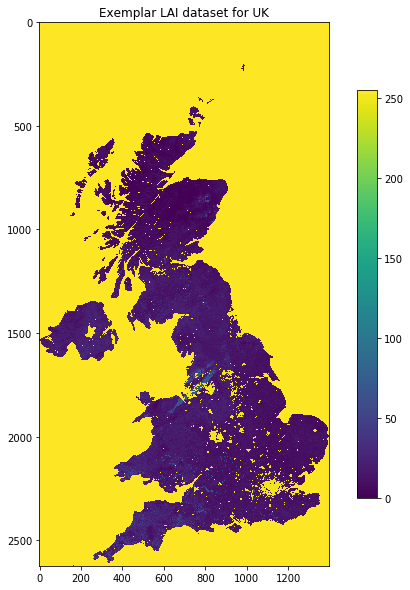

In [25]:
from osgeo import gdal, gdalconst,osr
import numpy as np
from geog0111.process_timeseries import mosaic_and_clip

# set to True if you want to override
# the MODIS projection (see above)
use_6974 = False

'''
https://stackoverflow.com/questions/10454316/
how-to-project-and-resample-a-grid-to-match-another-grid-with-gdal-python
'''
        
# first get an exemplar LAI file, clipped to
# the required limits. We will use this to match  
# the t2 dataset to
match_filename = mosaic_and_clip(tiles,1,year,ofolder='tmp',\
                    country_code=country_code,shpfile=shpfile,frmat='GTiff')

print(match_filename)

'''
Now get the projection, geotransform and dataset
size that we want to match to
'''
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

print('\nProjection from file:')
print(match_proj,'\n')

'''
set Projection 6974 from SR-OR
by setting use_6974 = True
'''
if use_6974:
    print('\nProjection 6974 from SR-ORG:')
    modis_wkt = 'data/modis_6974.wkt'
    match_proj = open(modis_wkt,'r').readline()
    match_ds.SetProjection(match_proj)
    print(match_proj,'\n')

'''
Visualise
'''
plt.figure(figsize=(10,10))
plt.title(f'Exemplar LAI dataset for {country_code}')
plt.imshow(match_ds.ReadAsArray())
plt.colorbar(shrink=0.75)
# close the file -- we dont need it any more
del match_ds

### 3.6.3.2 get information from source file


Now, we pull the information we need from the source file (the netcdf format t2 dataset).

We need to know:

* the data type
* the number of bands (time samples in this case)
* the geotransform of the dataset (the fact that it's 0.25 degree resolution over Europe)

and access these from the source dataset.



Information found
GeoTransform:    (-20.125, 0.25, 0.0, 75.125, 0.0, -0.25)
Projection:      GEOGCS["Coordinate System imported from GRIB file",DATUM["unknown",SPHEROID["Sphere",6371200,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]
number of bands: 365
format:          6
nx,ny:           321 261


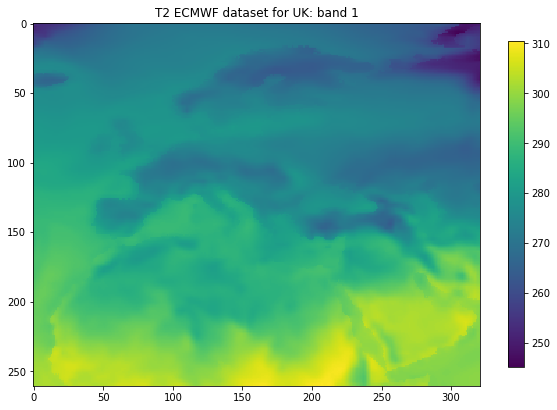

In [26]:
from osgeo import gdal, gdalconst,osr
import numpy as np

# set up conditions
src_filename = f'data/europe_data_{year}.nc'
'''
access information from source
'''
src_dataname = 'NETCDF:"'+src_filename+'":t2m'
src     = gdal.Open(src_filename, gdalconst.GA_ReadOnly)

'''
Get geotrans, data type and number of bands
from source dataset
'''
band1 = src.GetRasterBand(1)
src_proj = src.GetProjection()
src_geotrans = src.GetGeoTransform()
nbands = src.RasterCount
src_format = band1.DataType
nx = band1.XSize
ny = band1.YSize

print('Information found')
print('GeoTransform:   ',src_geotrans)
print('Projection:     ',src_proj)
print('number of bands:',nbands)
print('format:         ',src_format)
print('nx,ny:          ',nx,ny)

# read data
t2m = band1.ReadAsArray()
plt.figure(figsize=(10,10))
ax = plt.subplot ( 1, 1, 1)
ax.set_title(f'T2 ECMWF dataset for {country_code}: band 1')

im = plt.imshow(t2m)
_ = plt.colorbar(im,shrink=0.6)

### 3.6.3.4 reprojection

Now, set up a blank gdal dataset (in memory) with the size, data type, projection etc. that we want, the reproject the temperature dataset into this.

The processing may take some time if the LAI dataset is large (e.g. France).

The result will be of the same size, projection etc as the cropped LAI dataset.



In [27]:
dst = gdal.GetDriverByName('MEM').Create('', wide, high, nbands, src_format)

dst.SetGeoTransform( match_geotrans )
dst.SetProjection( match_proj)

print('Information found')
print('wide:      ',wide)
print('high:      ',high)
print('geotrans:  ',match_geotrans)
print('projection:',match_proj)

# Do the work: reproject the dataset
# This will take a few minutes, depending on dataset size
_ = gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)


Information found
wide:       1396
high:       2624
geotrans:   (-528121.3116353625, 463.22516403308435, 0.0, 6765601.113070521, 0.0, -463.28948030661667)
projection: PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


(-528121.3116353625, 118541.0173548233, 5549929.5167459585, 6765137.823590214)


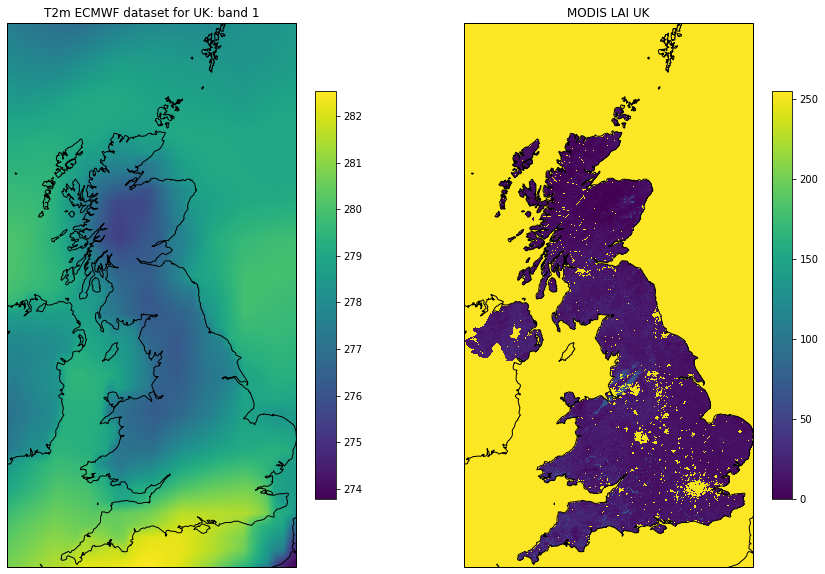

In [28]:
xOrigin = match_geotrans[0]
yOrigin = match_geotrans[3]
pixelWidth = match_geotrans[1]
pixelHeight = match_geotrans[5]

extent = (xOrigin,xOrigin+pixelWidth*wide,\
         yOrigin+pixelHeight*(high),yOrigin+pixelHeight)

print(extent)

'''
Visualise: takes some time to plot
           due to reprojections
'''
t2m = dst.GetRasterBand(1).ReadAsArray()
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly).ReadAsArray()

# visualise
plt.figure(figsize=(15,10))
ax = plt.subplot ( 1, 2, 1 ,projection=ccrs.Sinusoidal.MODIS)
ax.coastlines('10m')
ax.set_title(f'T2m ECMWF dataset for {country_code}: band 1')
im = ax.imshow(t2m[::-1],extent=extent)
plt.colorbar(im,shrink=0.75)


ax = plt.subplot ( 1, 2, 2 ,projection=ccrs.Sinusoidal.MODIS)
ax.coastlines('10m')
ax.set_title(f'MODIS LAI {country_code}')
im = plt.imshow(match_ds,extent=extent)
_ = plt.colorbar(im,shrink=0.75)

### 3.6.3.5 crop

Finally, we crop the temperature dataset using `gdal.Warp()` and save it to a (GeoTiff) file:

In [29]:
 # Output / destination
dst_filename = src_filename.replace('.nc',f'_{country_code}.tif')
frmat = 'GTiff'
g = gdal.Warp(dst_filename,
            dst,
            format=frmat,
            dstNodata=-300,
            cutlineDSName=shpfile,
            cutlineWhere=f"FIPS='{country_code:s}'",
            cropToCutline=True)
del dst # Flush
del g

data/europe_data_2017_UK.tif


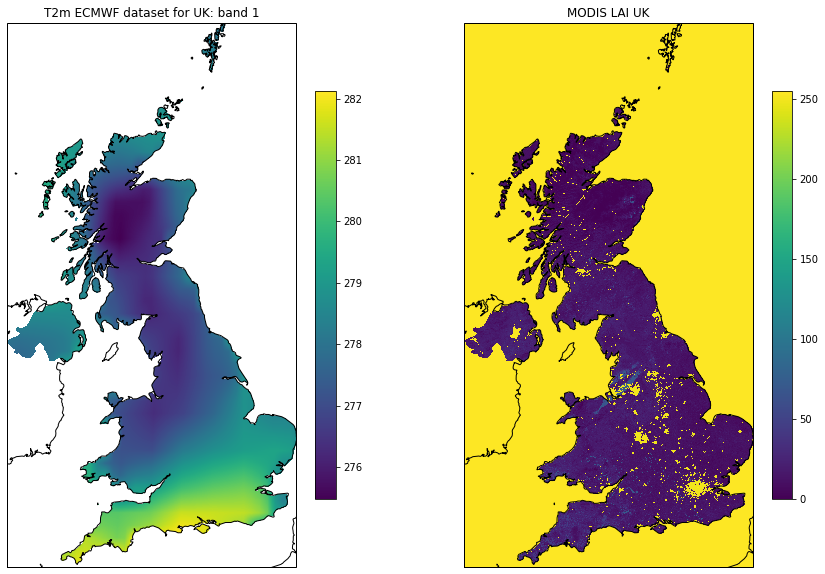

In [30]:
# visualise
print(dst_filename)
t2m = gdal.Open(dst_filename, gdalconst.GA_ReadOnly)
t2m = t2m.GetRasterBand(1).ReadAsArray()
t2m[t2m==-300] = np.nan
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly).ReadAsArray()

# visualise
plt.figure(figsize=(15,10))
ax = plt.subplot ( 1, 2, 1 ,projection=ccrs.Sinusoidal.MODIS)
ax.coastlines('10m')
ax.set_title(f'T2m ECMWF dataset for {country_code}: band 1')
im = ax.imshow(t2m[::-1],extent=extent)
plt.colorbar(im,shrink=0.75)

ax = plt.subplot ( 1, 2, 2 ,projection=ccrs.Sinusoidal.MODIS)
ax.coastlines('10m')
ax.set_title(f'MODIS LAI {country_code}')
im = plt.imshow(match_ds,extent=extent)
_ = plt.colorbar(im,shrink=0.75)

Now let's look at the time information in the metadata:

In [31]:
meta = gdal.Open(src_filename).GetMetadata()

print(meta['time#units'])

hours since 1900-01-01 00:00:00.0


The time information is in hours since `1900-01-01 00:00:00.0`. This is not such a convenient unit for plotting, so we can use `datetime` to fix that:


In [32]:
timer = meta['NETCDF_DIM_time_VALUES']
print(timer[:100])

{1025628,1025652,1025676,1025700,1025724,1025748,1025772,1025796,1025820,1025844,1025868,1025892,102


In [33]:
# split the string into integers
timer = [int(i) for i in meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')]

print (timer[:20])

[1025628, 1025652, 1025676, 1025700, 1025724, 1025748, 1025772, 1025796, 1025820, 1025844, 1025868, 1025892, 1025916, 1025940, 1025964, 1025988, 1026012, 1026036, 1026060, 1026084]


In [34]:
# split the string into integers
# convert to days
timer = [float(i)/24. for i in meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')]

print (timer[:20])

[42734.5, 42735.5, 42736.5, 42737.5, 42738.5, 42739.5, 42740.5, 42741.5, 42742.5, 42743.5, 42744.5, 42745.5, 42746.5, 42747.5, 42748.5, 42749.5, 42750.5, 42751.5, 42752.5, 42753.5]


In [35]:
from datetime import datetime,timedelta

# add base date
# split the string into integers
# convert to days
timer = [(datetime(1900,1,1) + timedelta(days=float(i)/24.)) \
         for i in meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')]

print (timer[:20])

[datetime.datetime(2017, 1, 1, 12, 0), datetime.datetime(2017, 1, 2, 12, 0), datetime.datetime(2017, 1, 3, 12, 0), datetime.datetime(2017, 1, 4, 12, 0), datetime.datetime(2017, 1, 5, 12, 0), datetime.datetime(2017, 1, 6, 12, 0), datetime.datetime(2017, 1, 7, 12, 0), datetime.datetime(2017, 1, 8, 12, 0), datetime.datetime(2017, 1, 9, 12, 0), datetime.datetime(2017, 1, 10, 12, 0), datetime.datetime(2017, 1, 11, 12, 0), datetime.datetime(2017, 1, 12, 12, 0), datetime.datetime(2017, 1, 13, 12, 0), datetime.datetime(2017, 1, 14, 12, 0), datetime.datetime(2017, 1, 15, 12, 0), datetime.datetime(2017, 1, 16, 12, 0), datetime.datetime(2017, 1, 17, 12, 0), datetime.datetime(2017, 1, 18, 12, 0), datetime.datetime(2017, 1, 19, 12, 0), datetime.datetime(2017, 1, 20, 12, 0)]


## 3.6.3.6 Putting this together

We can now put these codes together to make a function `match_netcdf_to_data()`:

In [38]:
from osgeo import gdal, gdalconst,osr
import numpy as np
from geog0111.process_timeseries import mosaic_and_clip
from datetime import datetime 

def match_netcdf_to_data(src_filename,match_filename,dst_filename,year,\
                         country_code=None,shpfile=None,\
                         nodata=-300,frmat='GTiff',verbose=False):

    '''
    see :
    https://stackoverflow.com/questions/10454316/
    how-to-project-and-resample-a-grid-to-match-another-grid-with-gdal-python
    '''

    '''
    Get the projection, geotransform and dataset
    size that we want to match to
    '''
    if verbose: print(f'getting info from match file {match_filename}')
    match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
    
    match_proj = match_ds.GetProjection()
    match_geotrans = match_ds.GetGeoTransform()
    wide = match_ds.RasterXSize
    high = match_ds.RasterYSize
    # close the file -- we dont need it any more
    del match_ds

    '''
    access information from source
    '''
    if verbose: print(f'getting info from source netcdf file {src_filename}')
    try:
        src_dataname = 'NETCDF:"'+src_filename+'":t2m'
        src = gdal.Open(src_dataname, gdalconst.GA_ReadOnly)
    except:
        if verbose: print('failed')
        return(None)
    
    # get meta data
    meta = gdal.Open(src_filename, gdalconst.GA_ReadOnly).GetMetadata()
    
    extent = [match_geotrans[0],match_geotrans[0]+match_geotrans[1]*wide,\
              match_geotrans[3]+match_geotrans[5]*high,match_geotrans[3]]
    # get time info
    timer = np.array([(datetime(1900,1,1) + timedelta(days=float(i)/24.)) \
         for i in meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')])
 
    '''
    Get geotrans, proj, data type and number of bands
    from source dataset
    '''
    band1 = src.GetRasterBand(1)
    src_geotrans = src.GetGeoTransform()
    src_proj = src.GetProjection()

    nbands = src.RasterCount
    src_format = band1.DataType
    
    dst = gdal.GetDriverByName('MEM').Create(\
                                    '', wide, high, \
                                    nbands, src_format)
    dst.SetGeoTransform( match_geotrans )
    dst.SetProjection( match_proj)

    if verbose: print(f'reprojecting ...')
        # Output / destination
    _ = gdal.ReprojectImage(src, dst, \
                                src_proj, \
                                match_proj,\
                                gdalconst.GRA_Bilinear )
    if verbose: print(f'cropping to {country_code:s} ...')
    done = gdal.Warp(dst_filename,
                    dst,
                    format=frmat,
                    dstNodata=nodata,
                    cutlineDSName=shpfile,
                    cutlineWhere=f"FIPS='{country_code:s}'",
                    cropToCutline=True)
    del dst
    return(timer,dst_filename,extent)

In [39]:
from osgeo import gdal, gdalconst,osr
import numpy as np
from geog0111.process_timeseries import mosaic_and_clip
from datetime import datetime,timedelta
from geog0111.match_netcdf_to_data import match_netcdf_to_data
from geog0111.geog_data import procure_dataset
from pathlib import Path

# set conditions

country_code = 'UK'
year = 2017
shpfile = "data/TM_WORLD_BORDERS-0.3.shp"
src_filename = f'data/europe_data_{year}.nc'
dst_filename = f'data/europe_data_{year}_{country_code}.tif'
t2_filename = f'data/europe_data_{year}_{country_code}.npz'
# read in the LAI data for given country code
tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")
        

#read LAI
fname = f'lai_data_{year}_{country_code}.npz'
ofile = Path('data')/fname
lai = np.load(ofile)

if not Path(t2_filename).exists():
    print(f'calculating dataset match in {t2_filename}')
    # first get an exemplar LAI file, clipped to
    # the required limits. We will use this to match  
    # the t2 dataset to
    match_filename = mosaic_and_clip(tiles,1,year,\
                        country_code=country_code,\
                        shpfile=shpfile,frmat='GTiff')
    '''
    Match the datasets using the function
    we have developed
    '''
    meta = gdal.Open(src_filename, gdalconst.GA_ReadOnly).GetMetadata()

    timer,dst_filename,extent = match_netcdf_to_data(\
                                    src_filename,match_filename,\
                                    dst_filename,year,\
                                    country_code=country_code,\
                                    shpfile=shpfile,\
                                    nodata=-300,frmat='GTiff',\
                                    verbose=True)

    # read and interpret the t2 data and flip
    temp2 = gdal.Open(dst_filename).ReadAsArray()[:,::-1]
    temp2[temp2==-300] = np.nan
    temp2 -= 273.15
    # save these
    print(f'saving data to {t2_filename}')
    np.savez(t2_filename,timer=timer,temp2=temp2,extent=extent)

else:
    print(f'dataset in {t2_filename} exists')
    
print('done')
t2data = np.load(t2_filename)
timer,temp2,extent = t2data['timer'],t2data['temp2'],t2data['extent']

dataset in data/europe_data_2017_UK.npz exists
done


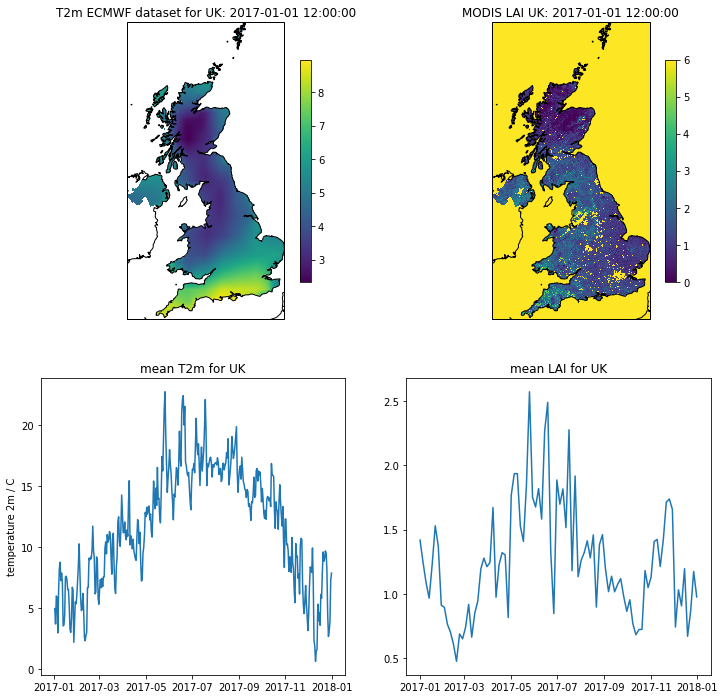

In [40]:
# visualise
import matplotlib.pylab as plt
import cartopy.crs as ccrs
%matplotlib inline

plt.figure(figsize=(12,12))
ax = plt.subplot ( 2, 2, 1 ,projection=ccrs.Sinusoidal.MODIS)
ax.coastlines('10m')
ax.set_title(f'T2m ECMWF dataset for {country_code}: {str(timer[0])}')
im = ax.imshow(temp2[0],extent=extent)
plt.colorbar(im,shrink=0.75)
3
ax = plt.subplot ( 2, 2, 2 ,projection=ccrs.Sinusoidal.MODIS)
ax.coastlines('10m')
ax.set_title(f'MODIS LAI {country_code}: {str(timer[0])}')
im = plt.imshow(lai['lai'][:,:,0],vmax=6,extent=extent)
_ = plt.colorbar(im,shrink=0.75)

plt.subplot ( 2, 2, 3 )
plt.title(f'mean T2m for {country_code}')
plt.plot(timer,np.nanmean(temp2,axis=(1,2)))
plt.ylabel('temperature 2m / C')
plt.subplot ( 2, 2, 4 )
plt.title(f'mean LAI for {country_code}')
num = np.nanmean(lai['lai']*lai['weights'],axis=(0,1))
den = np.nanmean(lai['weights'],axis=(0,1))
plt.plot(timer[::4],num/den)

## 3.6.4 Interpolate and save the LAI data

It is useful for many purposes to have a 'complete' dataset for LAI. We can achieve this by smoothing/interpolation as previously.

In [41]:
import scipy
import scipy.ndimage.filters

# want sigma as low as we can deal with, whilst 
# still interpolating effectively
sigma = 3

# read in the LAI data for given country code
fname = f'lai_data_{year}_{country_code}.npz'
ofile = Path('data')/fname

# read data from npz file
lai = np.load(ofile)

# set up filter
x = np.arange(-3*sigma,3*sigma+1)
gaussian = np.exp((-(x/sigma)**2)/2.0)

FIPS = country_code
dates, lai_array, weights_array = lai['dates'],lai['lai'],lai['weights']
print(lai_array.shape, weights_array.shape) #Check the output array shapes

numerator = scipy.ndimage.filters.convolve1d(lai_array * weights_array, gaussian, axis=2,mode='wrap')
denominator = scipy.ndimage.filters.convolve1d(weights_array, gaussian, axis=2,mode='wrap')

# avoid divide by 0 problems by setting zero values
# of the denominator to not a number (NaN)
denominator[denominator==0] = np.nan

interpolated_lai = numerator/denominator
print(interpolated_lai.shape)

# need to convert to dict to be able to assign
lai = dict(lai)
lai['interpolated_lai'] = interpolated_lai
np.savez(ofile,**lai)

(2624, 1396, 92) (2624, 1396, 92)
(2624, 1396, 92)


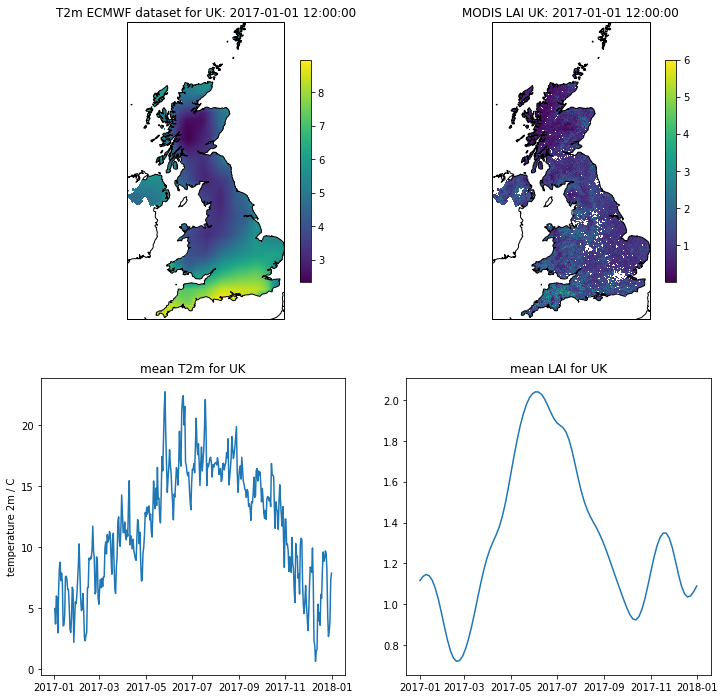

In [42]:
# visualise the interpolated dataset
import matplotlib.pylab as plt
import cartopy.crs as ccrs
%matplotlib inline

plt.figure(figsize=(12,12))
ax = plt.subplot ( 2, 2, 1 ,projection=ccrs.Sinusoidal.MODIS)
ax.coastlines('10m')
ax.set_title(f'T2m ECMWF dataset for {country_code}: {str(timer[0])}')
im = ax.imshow(temp2[0],extent=extent)
plt.colorbar(im,shrink=0.75)

ax = plt.subplot ( 2, 2, 2 ,projection=ccrs.Sinusoidal.MODIS)
ax.coastlines('10m')
ax.set_title(f'MODIS LAI {country_code}: {str(timer[0])}')
im = plt.imshow(interpolated_lai[:,:,0],vmax=6,extent=extent)
_ = plt.colorbar(im,shrink=0.75)

plt.subplot ( 2, 2, 3 )
plt.title(f'mean T2m for {country_code}')
plt.plot(timer,np.nanmean(temp2,axis=(1,2)))
plt.ylabel('temperature 2m / C')
plt.subplot ( 2, 2, 4 )
plt.title(f'mean LAI for {country_code}')
mean = np.nanmean(interpolated_lai,axis=(0,1))
plt.plot(timer[::4],mean)

## 3.6.7 Summary
 
In this section, we have learned about projections, and have reconciled two datasets that were originally in different projections. NThey also were defined with geoids with different Earth radius assumptions.

These issues are typical when dealing with geospatial data. 

This part of the notes is non compulsory, as the codes and ideas are quite complicated for people just begining to learn coding. We have included it here to allow students to revisit this later. It is also included because we want to develop some interesting datasets for modelling, so we need to deal with reconciling datasets from different providers in different projections.

In this section, we have developed the following datasets:

In [43]:
from geog0111.geog_data import procure_dataset
import numpy as np
from pathlib import Path

year = 2017
country_code = 'UK'
'''
LAI data
'''
# read in the LAI data for given country code
lai_filename = f'data/lai_data_{year}_{country_code}.npz'
# get the dataset in case its not here
procure_dataset(Path(lai_filename).name,verbose=False)

lai = np.load(lai_filename)
print(lai_filename,list(lai.keys()))

'''
T 2m data
'''
t2_filename = f'data/europe_data_{year}_{country_code}.npz'
# get the dataset in case its not here
procure_dataset(Path(t2_filename).name,verbose=False)
t2data = np.load(t2_filename)
print(t2_filename,list(t2data.keys()))

data/lai_data_2017_UK.npz ['dates', 'lai', 'weights', 'interpolated_lai']
data/europe_data_2017_UK.npz ['timer', 'temp2', 'extent']


In [46]:
# a quick look at some stats to see if there are data there
print(np.nanmean(t2data['temp2']),np.nanmean(lai['lai']),\
      np.nanmean(lai['weights']),np.nanmean(lai['interpolated_lai']))

11.758053 18.45137418797783 0.19862203366558234 1.3205721533916202


**Exercise 3.6.2** Extra Homework

Go carefully through these notes and make notes of the processes we have to go through to reconcile datasets such as these.

Learn what issues to look out for when coming across a new dataset, and how to use Python code to deal with it. Try to stick to one geospatial package as far as possible (`gdal` here) as you can make problems for yourself by mixing them.

In [ ]:
# do exercise here